#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$y \sim Exponential(\lambda),$$
where:
$$\lambda = exp(f) \in (0,+\infty)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In other words, given inputs $X$ and observations $Y$ drawn from exponential distribution with $\lambda = \lambda(X)$, we want to find $\lambda(X)$.

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [13]:
#here we specify a 'true' latent function lambda
#pick any or write your own

#scale = lambda x: 5*x+1e-2 #linear
#scale = lambda x: np.sin(2*np.pi*1*x)+1 #simple
scale = lambda x: np.sin(2*np.pi*3*x)*np.sin(2*np.pi*1/2*x)+1 #complex, NSample ~ 1000 required
#scale = lambda x: np.sin(2*np.pi*2/3*x)*np.cos(2*np.pi*7/2*x)+1 #complex, NSample ~ 1000 required

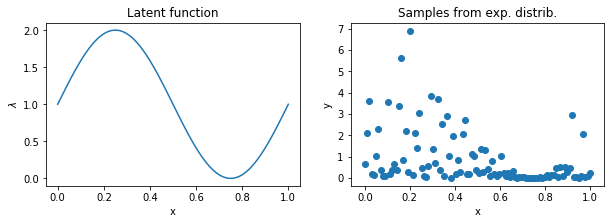

In [14]:
# here we generate some synthetic samples
NSamp = 100

X = np.linspace(0,1,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,3))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

Y = np.zeros_like(X)
for i,x in enumerate(X):
    Y[i] = np.random.exponential(scale(x), 1)
samples.scatter(X,Y)
samples.set_xlabel('x')
samples.set_ylabel('y')
samples.set_title('Samples from exp. distrib.')

fig.show()

In [15]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float()#.cuda()
train_y = torch.tensor(Y).float()#.cuda()

In [24]:
class PVGPRegressionModel(gpytorch.models.PyroVariationalGP):
    def __init__(self, train_x, train_y, likelihood, name_prefix="mixture_gp"):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_x.numel()
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, train_x, variational_distribution
        )
        
        # Standard initializtation
        super(PVGPRegressionModel, self).__init__(variational_strategy, likelihood, num_data=train_x.numel())
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        
        #we specify prior here
        #it is safer to underestimate the prior mean lengthscale than overestimate it
        #prior_rbf_length = 0.4 #for simple examples
        prior_rbf_length = 0.1 #for complex examples
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        )
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        #self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [25]:
from torch import Tensor
from typing import Any
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.distributions import MultivariateNormal, base_distributions
from gpytorch.utils.deprecation import _deprecate_kwarg_with_transform

class InfTheta_ExpDist_Likelihood(Likelihood):
    def __init__(self, noise_prior=None, noise_constraint=None, batch_shape=torch.Size(), **kwargs: Any):
        batch_shape = _deprecate_kwarg_with_transform(
            kwargs, "batch_size", "batch_shape", batch_shape, lambda n: torch.Size([n])
        )
        super(Likelihood, self).__init__()
        self._max_plate_nesting = 1

    def expected_log_prob(self, target: Tensor, input: MultivariateNormal, *params: Any, **kwargs: Any) -> Tensor:
        mean, variance = input.mean, input.variance
        theta = self.gplink_function(mean)
        res = - theta * target + theta.log()
        return res.sum(-1)
    
    @staticmethod
    def gplink_function(f: Tensor) -> Tensor:
        """
        GP link function transforms the GP latent variable `f` into :math:`\theta`,
        which parameterizes the distribution in :attr:`forward` method as well as the
        log likelihood of this distribution defined in :attr:`expected_log_prob`.
        """
        return f.exp()
    
    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any) -> base_distributions.Exponential:        
        theta = self.gplink_function(function_samples.mul(-1)) #it seems like function_samples are inverted
        return base_distributions.Exponential(theta)
    
    def marginal(self, function_dist: MultivariateNormal, *params: Any, **kwargs: Any) -> MultivariateNormal:
        mean, covar = function_dist.mean, function_dist.lazy_covariance_matrix
        return function_dist.__class__(mean, covar)

In [26]:
# define the model (optionally on GPU)
model = PVGPRegressionModel(train_x, train_y, InfTheta_ExpDist_Likelihood())#.cuda()

In [27]:
# train the model
from pyro import optim

base_lr = 5./NSamp
iter_print = 50

print('Basic lr for most parameters: {}'.format(base_lr))

#different hyperparameters need different learning rates
#these were optimized to run well on all examples (see above, where lambda is defined)
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": .1}
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": .1}
    elif param_name == 'variational_strategy.variational_distribution.chol_variational_covar':
        return {"lr": base_lr/5}
    else:
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf, means = [], [], []

means.append(model.variational_strategy.variational_distribution.\
             variational_mean.detach().cpu().numpy()) #save initial mean

def train(num_iter=200):
    elbo = pyro.infer.Trace_ELBO(num_particles=256, vectorize_particles=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        if not (i + 1) % iter_print:
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(),
            ))
            means.append(model.variational_strategy.variational_distribution.\
                         variational_mean.detach().cpu().numpy())
        
%time train()

Basic lr for most parameters: 0.05
Iter 50/200 - Loss: 1.14e+02   lengthscale: 0.071
Iter 100/200 - Loss: 98.6   lengthscale: 0.0804
Iter 150/200 - Loss: 92.3   lengthscale: 0.085
Iter 200/200 - Loss: 85.9   lengthscale: 0.0891
CPU times: user 6min 36s, sys: 36.6 s, total: 7min 13s
Wall time: 25.5 s


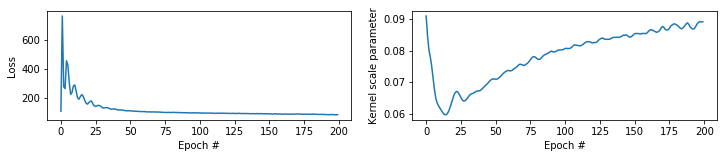

In [28]:
# prot loss function and kernel length
fig, (loss, kern) = plt.subplots(1,2,figsize=(12,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
fig.show()

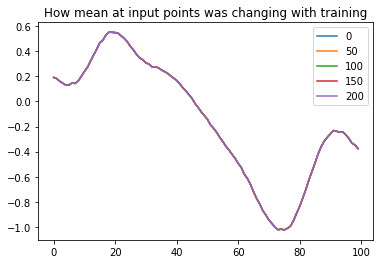

In [29]:
#this visualises the progress in learning mean values of lambda
#it is trivial for simple examples
for i,mean in enumerate(means):
    plt.plot(mean, label = "{}".format(iter_print*i))
plt.title('How mean at input points was changing with training')
plt.legend()
plt.show()

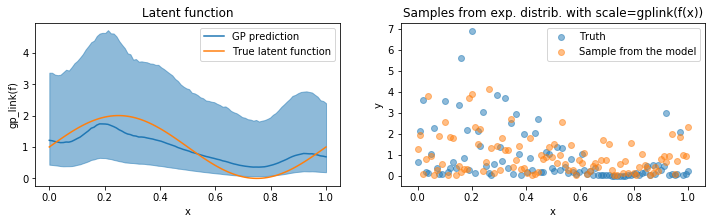

In [30]:
#visualize the result
fig, (func, samp) = plt.subplots(1,2,figsize=(12, 3))

model.eval()
with torch.no_grad():
    output = model.likelihood(model(train_x))
    
gplink = model.likelihood.gplink_function
    
F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(X, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(train_x.cpu().numpy(), gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(X,scale(X), label = 'True latent function')
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

Y_sim = np.zeros_like(Y)
for i, m in enumerate(F_mean): # sample from mean
#for i, m in enumerate(latent_sample):
    Y_sim[i] = np.random.exponential(m)
samp.scatter(X,Y, alpha = 0.5, label = 'Truth')
samp.scatter(X,Y_sim, alpha = 0.5, label = 'Sample from the model')
samp.set_xlabel('x')
samp.set_ylabel('y')
samp.set_title('Samples from exp. distrib. with scale=gplink(f(x))')
samp.legend()

fig.show()

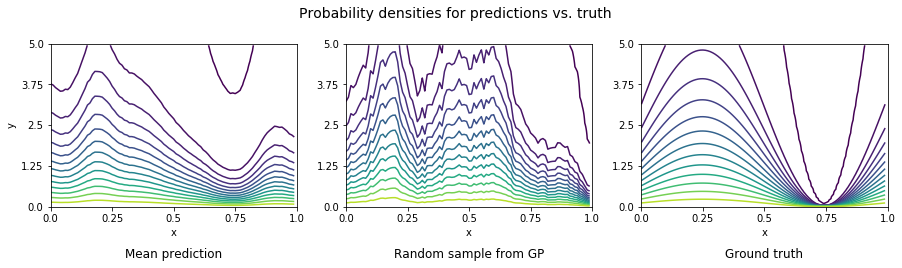

In [31]:
# visualize pdf for y(x)

from scipy import stats

Nbins = 100

latent_sample = gplink(output.sample()).cpu().numpy()

img = np.zeros((Nbins,NSamp,3))
h = np.linspace(1e-4,5,Nbins)

for i, (l, m, t) in enumerate(zip(latent_sample, F_mean, scale(X)+1e-2)):
    img[:,i,0] = stats.expon.pdf(h, scale=m)
    img[:,i,1] = stats.expon.pdf(h, scale=l)
    img[:,i,2] = stats.expon.pdf(h, scale=t)

img = img / np.max(img,axis=0) # normalize pdf, so that max(pdf) = 1

num_levels = 15

levels = np.exp(np.linspace(1e-4,1,num_levels))
levels -= 1
levels /= np.max(levels)

fig, ax = plt.subplots(1,3, figsize = (15,3))
for c, n in enumerate(['Mean prediction', 'Random sample from GP', 'Ground truth']):
    ax[c].contour(img[:,:,c], levels = levels)
    ax[c].set_yticks(np.linspace(0,Nbins,5))
    ax[c].set_yticklabels(np.linspace(0,5,5))
    ax[c].set_xticks(np.linspace(0,NSamp,5))
    ax[c].set_xticklabels(np.linspace(0,1,5))
    ax[c].set_xlabel('x')
    ax[c].set_title(n, y=-0.35)
ax[0].set_ylabel('y')
fig.suptitle('Probability densities for predictions vs. truth', y=1.05, fontsize=14);